In [7]:
import requests
import time
import csv
from collections import deque
import itertools
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Настройки
# ==========================
ACCESS_TOKEN = ""
API_VERSION = "5.199"
GROUP_MEMBERS = [332942361, 204201117]  # ID бригады
SLEEP_TIME = 0.4  # пауза между запросами

In [8]:
# ==========================
# 1. Получение данных из VK
# ==========================
def get_friends(user_id):
    url = "https://api.vk.com/method/friends.get"
    params = {
        "user_id": user_id,
        "access_token": ACCESS_TOKEN,
        "v": API_VERSION
    }
    response = requests.get(url, params=params).json()
    if "response" in response:
        return response["response"]["items"]
    else:
        print(f"Ошибка для {user_id}: {response}")
        return []

def build_network(user_ids):
    """Собирает связи для друзей и друзей друзей"""
    network = {}
    for uid in user_ids:
        friends = get_friends(uid)
        network[uid] = friends
        time.sleep(SLEEP_TIME)
    return network

def build_friends_of_friends(network):
    """Собирает друзей друзей"""
    network2 = {}
    all_friends = set()
    for friends in network.values():
        all_friends.update(friends)
    for friend_id in all_friends:
        friends_of_friend = get_friends(friend_id)
        network2[friend_id] = friends_of_friend
        time.sleep(SLEEP_TIME)
    return network2

def save_network_to_csv(network, filename):
    """Сохраняет сеть в CSV (source, target)"""
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["source", "target"])
        for user, friends in network.items():
            for friend in friends:
                writer.writerow([user, friend])

def load_network_from_csv(filename):
    """Загружает связи в граф (dict of sets)"""
    graph = {}
    with open(filename, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            src = int(row["source"])
            tgt = int(row["target"])
            graph.setdefault(src, set()).add(tgt)
            graph.setdefault(tgt, set()).add(src)
    return graph

In [9]:
# ==========================
# 2. Сбор и сохранение
# ==========================
# print("🔹 Сбор данных для членов группы...")
# friends_network = build_network(GROUP_MEMBERS)
# save_network_to_csv(friends_network, "friends.csv")
# print("💾 Сохранено: friends.csv")
#
# print("🔹 Сбор данных для друзей друзей...")
# friends_of_friends_network = build_friends_of_friends(friends_network)
# save_network_to_csv(friends_of_friends_network, "friends_of_friends.csv")
# print("💾 Сохранено: friends_of_friends.csv")

In [10]:
# ==========================
# 3. Чтение графа и анализ
# ==========================
print("📂 Загружаем графы...")
small_graph = load_network_from_csv("friends.csv")
big_graph = load_network_from_csv("friends_of_friends.csv")
print(f"✅ Загружено {len(small_graph)} узлов для друзей и {len(big_graph)} узлов для друзей друзей")

📂 Загружаем графы...
✅ Загружено 387 узлов для друзей и 61783 узлов для друзей друзей


In [11]:
# ==========================
# 4. Метрики центральности
# ==========================
from collections import deque
import itertools
import numpy as np

# --------------------------
# BFS для поиска кратчайших путей
# --------------------------
def bfs_shortest_paths(graph, start):
    """
    Возвращает словарь всех расстояний (число шагов) от узла `start` до всех достижимых узлов в графе.
    Использует алгоритм BFS (поиск в ширину).
    """
    visited = {start: 0}          # словарь: {узел: расстояние от start}, start=0
    queue = deque([start])        # очередь для BFS
    while queue:                  # пока есть узлы для обработки
        node = queue.popleft()    # достаём узел из очереди
        for neighbor in graph.get(node, []):  # перебор соседей текущего узла
            if neighbor not in visited:       # если сосед ещё не посещён
                visited[neighbor] = visited[node] + 1  # расстояние = расстояние до текущего +1
                queue.append(neighbor)        # добавляем соседа в очередь для дальнейшей обработки
    return visited  # возвращаем словарь расстояний от start до всех достижимых узлов

# --------------------------
# Центральность по близости (closeness)
# --------------------------
def closeness_centrality(graph):
    """
    Вычисляет центральность по близости для всех узлов.
    Чем меньше среднее расстояние от узла до всех достижимых остальных узлов, тем выше centrality.
    """
    centrality = {}
    nodes = list(graph.keys())   # список всех узлов
    for i, node in enumerate(nodes, 1):
        distances = bfs_shortest_paths(graph, node)  # получаем кратчайшие расстояния от node
        reachable_count = len(distances) - 1        # исключаем сам узел
        if reachable_count > 0:
            # формула: количество достижимых узлов / сумма расстояний до них
            centrality[node] = reachable_count / sum(distances.values())
        else:
            centrality[node] = 0  # если нет достижимых других узлов
        # вывод прогресса каждые 5%
        if i % max(1, len(nodes) // 20) == 0:
            print(f"🔸 Closeness: {i/len(nodes)*100:.1f}% завершено")
    return centrality

# --------------------------
# Центральность по посредничеству (betweenness)
# --------------------------
def betweenness_centrality(graph):
    """
    Центральность по посредничеству: узел важен, если через него проходят многие кратчайшие пути
    между другими узлами.
    """
    centrality = {v: 0 for v in graph}  # инициализация centrality=0 для всех узлов
    nodes = list(graph.keys())
    total_pairs = len(nodes) * (len(nodes) - 1) / 2  # общее число уникальных пар узлов
    processed = 0  # счётчик обработанных пар

    for s, t in itertools.combinations(nodes, 2):  # перебираем все пары узлов (s,t)
        paths = [[s]]        # текущие пути в BFS начинаем с узла s
        shortest_paths = []  # список найденных кратчайших путей
        while paths:
            new_paths = []
            for path in paths:
                last = path[-1]  # последний узел в текущем пути
                for neighbor in graph.get(last, []):  # перебираем соседей
                    if neighbor in path:  # избегаем циклов
                        continue
                    new_path = path + [neighbor]  # создаём новый путь с добавлением соседа
                    if neighbor == t:
                        shortest_paths.append(new_path)  # путь достиг цели t → сохраняем
                    else:
                        new_paths.append(new_path)       # продолжим BFS
            if shortest_paths:
                break  # нашли кратчайшие пути → выходим из BFS
            paths = new_paths

        # обновляем значение посредничества для всех промежуточных узлов
        for path in shortest_paths:
            for v in path[1:-1]:  # пропускаем первый и последний узел (s и t)
                centrality[v] += 1 / len(shortest_paths)  # делим вклад на число кратчайших путей
        processed += 1
        # вывод прогресса каждые 5%
        if processed % max(1, int(total_pairs // 20)) == 0:
            print(f"🔸 Betweenness: {processed / total_pairs * 100:.1f}% завершено")
    return centrality

# --------------------------
# Центральность собственного вектора (eigenvector)
# --------------------------
def eigenvector_centrality(graph, iterations=100, tol=1e-6):
    """
    Центральность собственного вектора: узел важен, если он связан с другими важными узлами.
    Итеративный метод для поиска собственного вектора матрицы смежности.
    """
    nodes = list(graph.keys())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}  # отображение узел → индекс
    A = np.zeros((n, n))  # матрица смежности размером n*n
    for i, node in enumerate(nodes):
        for neighbor in graph[node]:
            if neighbor in node_index:
                A[i, node_index[neighbor]] = 1  # ставим 1 в матрице смежности

    x = np.ones(n)  # начальный вектор (все элементы 1)
    for iteration in range(iterations):
        x_new = A.dot(x)           # умножаем матрицу на вектор
        x_new /= np.linalg.norm(x_new)  # нормируем вектор (чтобы не росли значения)
        diff = np.linalg.norm(x - x_new)  # вычисляем изменение вектора
        if iteration % max(1, iterations // 10) == 0:
            print(f"🔸 Eigenvector: {iteration / iterations * 100:.0f}% завершено")
        if diff < tol:  # если вектор почти не изменился → считаем, что сошлось
            break
        x = x_new  # обновляем вектор
    print("🔸 Eigenvector: 100% завершено")
    return {nodes[i]: x[i] for i in range(n)}  # возвращаем словарь {узел: centrality}


🔹 Вычисляем центральности...
🔸 Closeness: 5.0% завершено
🔸 Closeness: 10.0% завершено
🔸 Closeness: 15.0% завершено
🔸 Closeness: 20.0% завершено
🔸 Closeness: 25.0% завершено
🔸 Closeness: 30.0% завершено
🔸 Closeness: 35.0% завершено
🔸 Closeness: 40.0% завершено
🔸 Closeness: 45.0% завершено
🔸 Closeness: 50.0% завершено
🔸 Closeness: 55.0% завершено
🔸 Closeness: 60.0% завершено
🔸 Closeness: 65.0% завершено
🔸 Closeness: 70.0% завершено
🔸 Closeness: 75.0% завершено
🔸 Closeness: 80.0% завершено
🔸 Closeness: 85.0% завершено
🔸 Closeness: 90.0% завершено
🔸 Closeness: 95.0% завершено
🔸 Closeness: 100.0% завершено
🔸 Betweenness: 5.0% завершено
🔸 Betweenness: 10.0% завершено
🔸 Betweenness: 15.0% завершено
🔸 Betweenness: 20.0% завершено
🔸 Betweenness: 25.0% завершено
🔸 Betweenness: 30.0% завершено
🔸 Betweenness: 35.0% завершено
🔸 Betweenness: 40.0% завершено
🔸 Betweenness: 45.0% завершено
🔸 Betweenness: 50.0% завершено
🔸 Betweenness: 55.0% завершено
🔸 Betweenness: 60.0% завершено
🔸 Betweenness: 65.0%

,id,closeness,betweenness,eigenvector
23165,5292392,1.0000,0.0,1.076960e-11
26176,46193283,0.5001,0.0,1.076960e-11
59377,20704347,0.5001,0.0,1.076960e-11
52206,897506,0.5001,0.0,1.076960e-11
31791,121833588,0.5001,0.0,1.076960e-11
10025,80237575,0.5001,0.0,1.076960e-11
52134,39301432,0.5001,0.0,1.076960e-11
52324,92910308,0.5001,0.0,1.076960e-11
52150,60535130,0.5001,0.0,1.076960e-11
10050,86529092,0.5001,0.0,1.076960e-11


=== ТОП-10 по BETWEENNESS ===


,id,closeness,betweenness,eigenvector
9100,332942361,0.304225,24531.0,5.948003e-05
57446,204201117,0.356408,13203.0,1.640716e-02
3,464257026,0.222243,0.0,2.017215e-04
61810,170524669,0.243992,0.0,1.414488e-05
18,595460136,0.222779,0.0,2.202704e-03
4,278921228,0.228590,0.0,1.194855e-03
5,104464397,0.202163,0.0,5.306486e-07
6,100401166,0.228590,0.0,1.194855e-03
7,267649039,0.288518,0.0,9.300760e-02
8,249692176,0.216978,0.0,4.587923e-06


=== ТОП-10 по EIGENVECTOR ===


,id,closeness,betweenness,eigenvector
24273,13945608,0.256440,0.0,0.396123
18995,7511628,0.254445,0.0,0.356644
54445,153601085,0.254482,0.0,0.316322
61105,16251515,0.294958,0.0,0.249673
22264,2406949,0.288452,0.0,0.187452
27739,466020195,0.286634,0.0,0.135780
7,267649039,0.288518,0.0,0.093008
17787,297178224,0.296326,0.0,0.073606
21694,237286750,0.279967,0.0,0.058482
24505,29281481,0.255385,0.0,0.030301


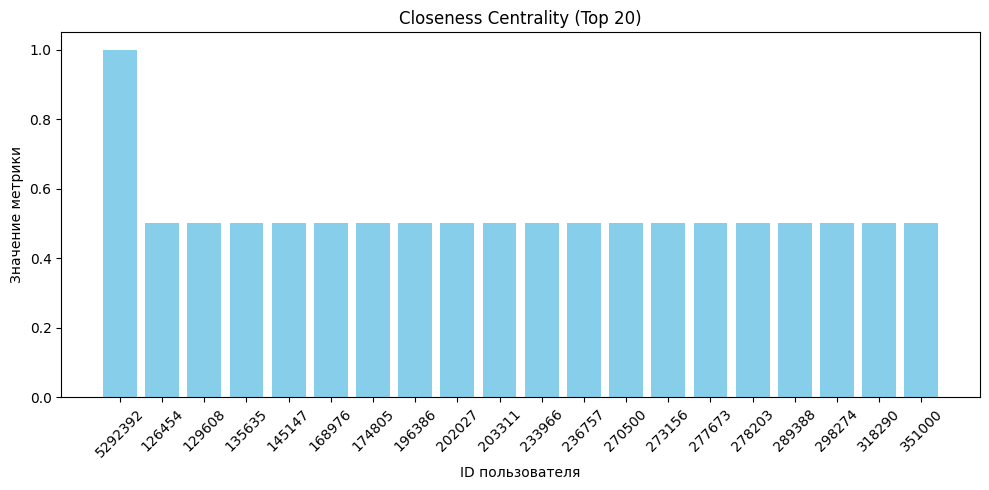

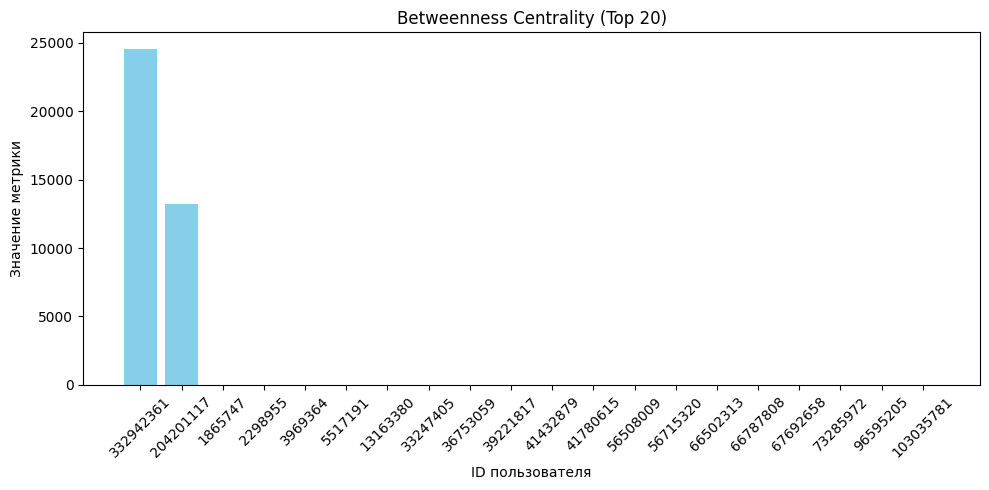

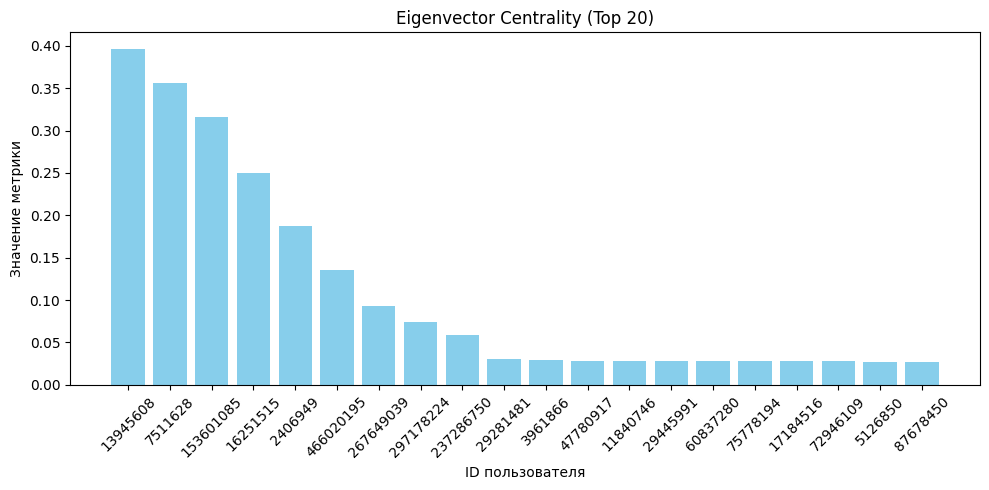

In [12]:
# ==========================
# 5. Расчёт и вывод
# ==========================
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

print("🔹 Вычисляем центральности...")

closeness = closeness_centrality(big_graph)       # Центральность по близости
betweenness = betweenness_centrality(small_graph)   # Центральность по посредничеству
eigenvector = eigenvector_centrality(big_graph)   # Центральность собственного вектора

# Объединяем все узлы из обоих графов для DataFrame
all_nodes = set(big_graph.keys()).union(set(small_graph.keys()))

# Создаём DataFrame с корректным соответствием метрик
df = pd.DataFrame({
    "id": list(all_nodes),
    "closeness": [closeness.get(n, 0) for n in all_nodes],       # знач. closeness из big_graph
    "betweenness": [betweenness.get(n, 0) for n in all_nodes],   # знач. betweenness из small_graph, остальным 0
    "eigenvector": [eigenvector.get(n, 0) for n in all_nodes],   # знач. eigenvector из big_graph
})

# Функция для отображения топ-N пользователей по метрике
def show_top(metric, top_n=10):
    """
    Сортирует DataFrame по заданной метрике и выводит топ-N пользователей.
    metric: строка - название колонки ('closeness', 'betweenness', 'eigenvector')
    top_n: количество строк для отображения
    """
    print(f"=== ТОП-{top_n} по {metric.upper()} ===")
    # сортируем по метрике и берём top_n
    display(df.sort_values(metric, ascending=False).head(top_n))

# Выводим топ-10 по каждой метрике
show_top("closeness", top_n=10)
show_top("betweenness", top_n=10)
show_top("eigenvector", top_n=10)

# Сохраняем результаты в CSV на всякий случай
df.to_csv("centrality_results.csv", index=False, encoding="utf-8")

# --------------------------
# Функция для построения графика распределения центральности
# --------------------------
def plot_centrality_graph(centrality_dict, title, top_n=20):
    """
    Строит столбчатый график top_n узлов по заданной метрике.
    centrality_dict: словарь {узел: значение метрики}
    title: название графика
    top_n: сколько топ-узлов отображать
    """
    # Сортируем по значению метрики, берём топ N
    sorted_items = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    nodes, values = zip(*sorted_items)  # распаковываем ID и значения метрики

    plt.figure(figsize=(10,5))
    plt.bar([str(n) for n in nodes], values, color='skyblue')
    plt.title(title)
    plt.xlabel("ID пользователя")
    plt.ylabel("Значение метрики")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --------------------------
# Строим графики по каждой метрике
# --------------------------
plot_centrality_graph(closeness, "Closeness Centrality (Top 20)")
plot_centrality_graph(betweenness, "Betweenness Centrality (Top 20)")
plot_centrality_graph(eigenvector, "Eigenvector Centrality (Top 20)")
